In [1]:
import numpy as np
import ast
import matplotlib.pyplot as plt
import os

In [2]:
path = '/global/homes/v/vboehm/codes/postlimber/output/'

In [3]:
#cosmology
h         = 0.6770
omega_cdm = 0.11923
omega_b   = 0.02247
Omega_b   = omega_b/h**2
Omega_cdm = omega_cdm/h**2
Omega_m   = Omega_b+Omega_cdm
ns        = 0.96824
A0        = 2.10732*10**(-9)

#dictionary for class
cosmo_dict={'h': h,
'omega_b' : omega_b,
'omega_cdm': omega_cdm,
'A_s'    : A0,
'n_s'    : ns,
'k_pivot' : 0.05}
print(cosmo_dict)


c      = 299792458/1000. #km/s

#prefactor for Cl_kk computation from Cl_dd
prefac = 1.5*Omega_m*(100.)**2/c**2 #without h

{'h': 0.677, 'omega_b': 0.02247, 'omega_cdm': 0.11923, 'A_s': 2.10732e-09, 'n_s': 0.96824, 'k_pivot': 0.05}


In [4]:
#get comoving distance from integrating c/H_0/E(z)
def integrand(z):
    return c/(100.)*(Omega_m*(1.+z)**3+(1.-Omega_m))**(-0.5)#Mpc/h

def chi(z):
    z_ = np.arange(0.,z,0.0001)
    res = np.trapz(integrand(z_),z_)
    return res

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/matplotlib/axes/_base.py:3157: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


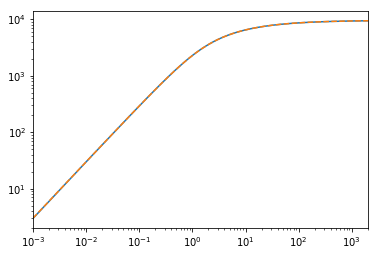

In [5]:
#get z_cmb and comving distance from class

from classy import Class
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
cosmo_b               = cosmo.get_background()

class_z               = cosmo_b['z'][::-1]
class_chi             = cosmo_b['comov. dist.'][::-1]

derivParams           = cosmo.get_current_derived_parameters(['z_rec'])
z_cmb                 = derivParams['z_rec']*h


from scipy.interpolate import InterpolatedUnivariateSpline as ius
chi_z = ius(class_z,class_chi*h)#Mpc/h

#check if interpolation works
z_=np.logspace(-3,3.5)
plt.figure()
plt.loglog(class_z,class_chi*h)
plt.loglog(z_,chi_z(z_),ls='--')
plt.xlim(0,2000)
plt.show()

In [6]:
#read in ells and header of one file, compare chis in header with computed ones
fname= 'C_ell_z1_0.2100_z2_0.07877_lmin2_lmax2000.dat'
data = np.loadtxt(path+fname,skiprows=1)
ell  = data[:,0]

with open(path+fname) as f:
    a= f.readline().split(',')
    f.close()
print(a)
print('chi(z1) Class', chi_z(0.21)*h)
print('my chi(z1)', chi(0.21))
print('chi(z2), CLASS',chi_z(0.07877))

#set chi_cmb
chi_cmb = chi(z_cmb)
print('Distance to CMB:',chi_cmb)

[' C_ell(z1', 'z2)', ' z1 = 0.21', ' z2 = 0.07877', ' chi(z1) = 598.36020', ' chi(z2) = 231.92482\n']
chi(z1) Class 404.80111043047987
my chi(z1) 597.6768634207303
chi(z2), CLASS 231.7691175854956
Distance to CMB: 9391.014474292815


low z1: [0.011 0.21  0.41  0.61  0.81 ]
1859
2897
229
123
83
[0. 0. 0. 0. 0.]


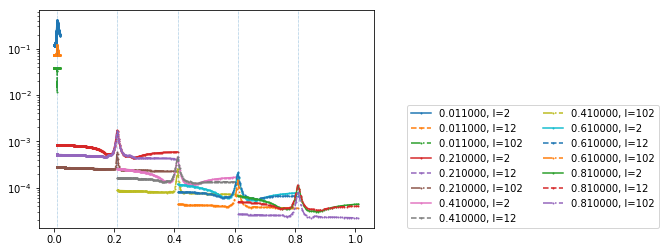

In [7]:
import fnmatch
#not very elegant, but seems to do the job: read in Cdd_ells

# this is the loop for low redshifts

z1s1 = np.arange(0.21,1.01,0.2)
z1s1 = np.insert(z1s1,0,0.011)

print('low z1:',z1s1)

C_ells1 = []
z2s1 = []
z1_=[]
for z1 in z1s1:
    z2=[]
    C_ells=[]
    for file in os.listdir(path):
        if fnmatch.fnmatch(file, 'C_ell_z1_%.5f_z2*.dat'%z1):
            z1_+=[z1]
            C_ells +=[np.loadtxt(path+file,skiprows=1)[:,1]]
            
            try:
                z2+=[ast.literal_eval(file[20:28])]
            except:
                try: 
                    z2+=[ast.literal_eval(file[20:27])]
                except:
                    z2+=[ast.literal_eval(file[20:26])]
        
        if fnmatch.fnmatch(file, 'C_ell_z1_%.4f_z2*.dat'%z1):
            z1_+=[z1]
            C_ells +=[np.loadtxt(path+file,skiprows=1)[:,1]]
            
            try:
                z2+=[ast.literal_eval(file[19:26])]
            except:
                try: 
                    z2+=[ast.literal_eval(file[19:25])]
                except:
                    z2+=[ast.literal_eval(file[19:24])]
    print(len(z2))
    assert(len(z2)==len(np.unique(z2)))
    z2 = np.asarray(z2)
    ii = np.argsort(z2)
    plt.semilogy(z2[ii],np.asarray(C_ells)[ii,0],marker='o',markersize='1',label='%f, l=%d'%(z1,ell[0]))
    plt.semilogy(z2[ii],np.asarray(C_ells)[ii,10],marker='o',ls='--',markersize='1',label='%f, l=%d'%(z1,ell[10]))
    plt.semilogy(z2[ii],np.asarray(C_ells)[ii,100],marker='o',ls='-.',markersize='1',label='%f, l=%d'%(z1,ell[100]))
    plt.axvline(z1,lw=0.5,ls=':')
    z2s1+=[z2]
    C_ells1+=[C_ells]
plt.legend(ncol=2,loc=(1.1,0))
print(z1s1-np.unique(z1_))

high z1: [1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4
 4.6 4.8]
62
48
38
32
27
23
20
18
16
14
13
11
10
10
9
8
8
7
7
6
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


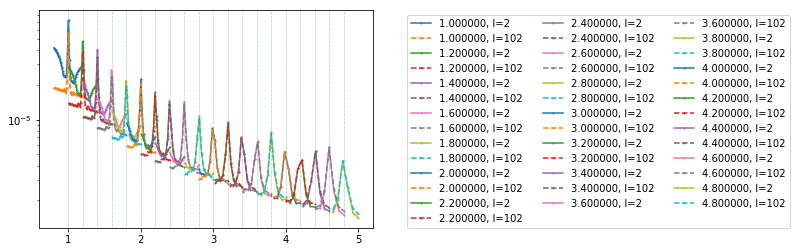

In [8]:
#high redshift z1s
#loop over these z1s
z1s2 = np.arange(1.0,5,0.2)

print('high z1:', z1s2)
ll_=0
C_ells2 = []
z2s2 = []
z1_=[]
plt.figure()
for z1 in z1s2:
    z2=[]
    C_ells=[]
    for file in os.listdir(path):
        if fnmatch.fnmatch(file, 'C_ell_z1_%.3f_z2*.dat'%z1):
            z1_+=[z1]
            C_ells+=[np.loadtxt(path+file,skiprows=1)[:,1]]
            #print(file)
            try:
                z2+=[ast.literal_eval(file[18:25])]
            except:
                try: 
                    z2+=[ast.literal_eval(file[18:24])]
                except:
                    z2+=[ast.literal_eval(file[18:23])]
    assert(len(z2)==len(np.unique(z2)))
    print(len(z2))
    z2 = np.asarray(z2)
    ii = np.argsort(z2)
    plt.semilogy(z2[ii],np.asarray(C_ells)[ii,1],marker='o',markersize='1',label='%f, l=%d'%(z1,ell[0]))
    plt.semilogy(z2[ii],np.asarray(C_ells)[ii,100],ls='--',marker='o',markersize='1',label='%f, l=%d'%(z1,ell[100]))
    plt.axvline(z1,lw=0.5,ls=':')
    z2s2+=[z2]
    C_ells2+=[C_ells]
plt.legend(ncol=3,loc=(1.1,0))
print(z1s2-np.unique(z1_))
z2s2=np.asarray(z2s2)

In [9]:

C_ells1 = np.asarray(C_ells1)
C_ells2 = np.asarray(C_ells2)


C_ells  = np.append(C_ells1,C_ells2)

print(C_ells1.shape)
print(C_ells2.shape)
print(C_ells.shape)


z2s1 = np.asarray(z2s1)
z2s2 = np.asarray(z2s2)
z2s  = np.append(z2s1,z2s2)
z2s  = np.asarray(z2s)


print(z2s1.shape)
print(z2s2.shape)
print(z2s.shape)



z1s = np.concatenate((z1s1,z1s2))

print(z1s)

(5,)
(20,)
(25,)
(5,)
(20,)
(25,)
[0.011 0.21  0.41  0.61  0.81  1.    1.2   1.4   1.6   1.8   2.    2.2
 2.4   2.6   2.8   3.    3.2   3.4   3.6   3.8   4.    4.2   4.4   4.6
 4.8  ]


In [10]:
def lensing_kernel(chi_max, chi_z):
    def kernel(z):
        chi = chi_z(z)
        return chi*(chi_max-chi)/chi_max*(1.+z)
    return kernel

In [11]:
W = lensing_kernel(chi_cmb, chi_z)

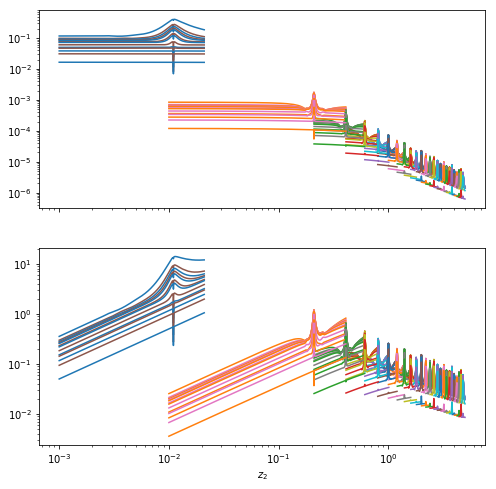

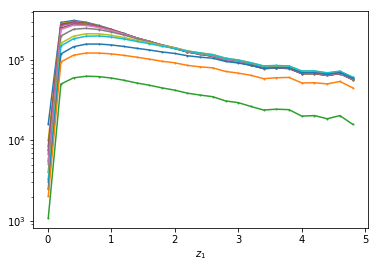

In [12]:
#chi(z1)
chi1 = chi_z(z1s)
CLkk = []
#ell indices
index = [0,2,3,4,5,8,10,20,40,50,100,200,500]
f1, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8))
f2, ax = plt.subplots()
for ll in index:
    res=[]
    for jj, z1 in enumerate(z1s):
        z2_ = z2s[jj]
        ii  = np.argsort(z2_)
        z2_ = np.asarray(z2_)
        z2_ = z2_[ii]
        C_ell = np.asarray(C_ells[jj])[ii,ll]
        ax1.loglog(z2_,C_ell,ls='-')
        ax2.loglog(z2_,W(z2_)*C_ell,ls='-')
        res+=[np.trapz(W(z2_)*C_ell,chi_z(z2_))]
    CLkk+=[np.trapz(res*W(z1s),chi1)]
    ax.semilogy(z1s,res*W(z1s),marker='o',markersize=1)
ax2.set_xlabel('$z_2$')   
ax.set_xlabel('$z_1$')
CLkk = np.asarray(CLkk)*prefac**2        
    

In [13]:
L = ell[index]


In [14]:
cosmo_dict={'h': h,
'omega_b' : omega_b,
'omega_cdm': omega_cdm,
'A_s'    : A0,
'n_s'    : ns,
'k_pivot' : 0.05}
cosmo_dict['output']='lCl, tCl'
cosmo_dict['l_max_scalars']=2000
cosmo_dict['lensing']='yes'

In [15]:
cosmo.empty()
cosmo.set(cosmo_dict)

True

In [16]:
cosmo.compute()

In [17]:
cllen= cosmo.lensed_cl(lmax=1000)

In [18]:
ll = cllen['ell']
clpp = cllen['pp']

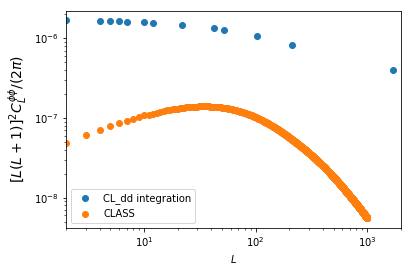

In [23]:
plt.figure()
plt.loglog(L,4*CLkk/2./np.pi,ls='',marker='o',label='CL_dd integration')
plt.loglog(ll,(ll*(ll+1))**2*clpp/2./np.pi,ls='',marker='o',label='CLASS')
#plt.loglog(L,4*(L*(L+1.))**2/L**4*CLkk/2./np.pi,ls='',marker='o',label='prefac correction')
plt.ylabel('$[L(L+1)]^2 C_L^{\phi\phi}/(2 \pi)$',fontsize=14)
plt.xlabel('$L$')
plt.xlim(2,2000)
plt.legend()
plt.savefig('../figures/Cls.png')
plt.show()